In [44]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import sys
import copy
import time
import random
import pyspark
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
import seaborn as sns

# for creating pipelines and model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Predictive Maintenance") \
        .config("spark.some.config.option", "some-value") \
        .config("spark.executor.memory", "70g")\
        .config("spark.driver.memory", "50g")\
        .config("spark.memory.offHeap.enabled", "true")\
        .config("spark.memory.offHeap.size","30g")\
        .getOrCreate()
    return spark

spark = init_spark()

In [18]:
filename = "../data/machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

100
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model3| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model3|  2|
|        6|model3|  7|
|        7|model3| 20|
|        8|model3| 16|
|        9|model4|  7|
|       10|model3| 10|
|       11|model2|  6|
|       12|model3|  9|
|       13|model1| 15|
|       14|model3|  1|
|       15|model3| 14|
|       16|model1|  3|
|       17|model1| 14|
|       18|model3| 15|
|       19|model3| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [19]:
feat_data = spark.read.parquet('../data/labeled_features.parquet')
feat_data = feat_data.withColumn("age", feat_data.age.cast(DoubleType()))
feat_data = feat_data.withColumnRenamed("label_e", "label")

print(feat_data.count())
# highly imbalanced data
label_count_pd = feat_data.groupby('label').count().toPandas()
feat_data.limit(10).toPandas().head(10)

73142


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label
0,2016-01-01 07:00:00,172.083928,453.576897,101.303110,40.627410,169.230878,451.007306,100.487259,40.839262,167.339602,...,0.0,579.0,534.0,474.0,459.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
1,2015-12-31 19:00:00,168.173348,453.181951,99.527531,40.981132,165.787189,449.842118,100.598808,41.791947,166.190766,...,0.0,578.0,533.0,473.0,458.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
2,2015-12-31 07:00:00,163.401030,446.502286,101.670084,42.602762,165.199475,445.038344,101.074817,41.722713,168.995817,...,0.0,578.0,533.0,473.0,458.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
3,2015-12-30 19:00:00,166.997919,443.574402,100.479550,40.842664,171.793211,450.456864,100.955598,40.418503,172.419415,...,0.0,577.0,532.0,472.0,457.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
4,2015-12-30 07:00:00,176.588502,457.339327,101.431647,39.994342,175.130162,466.483595,99.468624,40.920312,174.914358,...,0.0,577.0,532.0,472.0,457.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
5,2015-12-29 19:00:00,173.671822,475.627863,97.505602,41.846282,174.077285,464.681249,99.852795,41.520096,173.561514,...,0.0,576.0,531.0,471.0,456.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
6,2015-12-29 07:00:00,174.482749,453.734636,102.199989,41.193909,173.506360,450.268077,101.890206,39.760938,173.318924,...,0.0,576.0,531.0,471.0,456.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
7,2015-12-28 19:00:00,172.529971,446.801518,101.580424,38.327966,172.737011,443.114257,99.159233,38.946824,171.416655,...,0.0,575.0,530.0,470.0,455.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
8,2015-12-28 07:00:00,172.944052,439.426996,96.738042,39.565681,170.859997,444.430674,99.034004,39.874349,172.384220,...,0.0,575.0,530.0,470.0,455.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0
9,2015-12-27 19:00:00,168.775941,449.434352,101.329965,40.183016,172.104304,444.571586,98.413556,39.550401,170.807337,...,0.0,574.0,529.0,469.0,454.0,model4,3.0,"(0.0, 1.0, 0.0)",0.0,0.0


As we can see, the data is very imbalanced.

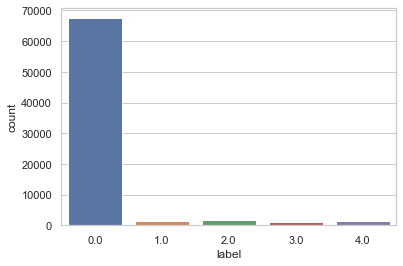

In [20]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="label", y="count", data=label_count_pd)

In [23]:
label_var = ['label']
key_cols =['machineID','dt_truncated']
input_features = feat_data.columns
remove_cols = label_var + key_cols + ['failure','model_encoded','model' ]

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_cols)]
# Use cols
input_features

['volt_rollingmean_12',
 'rotate_rollingmean_12',
 'pressure_rollingmean_12',
 'vibration_rollingmean_12',
 'volt_rollingmean_24',
 'rotate_rollingmean_24',
 'pressure_rollingmean_24',
 'vibration_rollingmean_24',
 'volt_rollingmean_36',
 'vibration_rollingmean_36',
 'rotate_rollingmean_36',
 'pressure_rollingmean_36',
 'volt_rollingstd_12',
 'rotate_rollingstd_12',
 'pressure_rollingstd_12',
 'vibration_rollingstd_12',
 'volt_rollingstd_24',
 'rotate_rollingstd_24',
 'pressure_rollingstd_24',
 'vibration_rollingstd_24',
 'volt_rollingstd_36',
 'rotate_rollingstd_36',
 'pressure_rollingstd_36',
 'vibration_rollingstd_36',
 'error1sum_rollingmean_24',
 'error2sum_rollingmean_24',
 'error3sum_rollingmean_24',
 'error4sum_rollingmean_24',
 'error5sum_rollingmean_24',
 'comp1sum',
 'comp2sum',
 'comp3sum',
 'comp4sum',
 'age']

In [24]:
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
feat_data = va.transform(feat_data).select('machineID','dt_truncated','label','features')

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(feat_data)

# split the data into train/test based on date
split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)

# Undersampling
training = training.sampleBy('label', fractions={0: 0.2, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}, seed=0)

print(training.count())
print(testing.count())

15894
12708


In [25]:
## show the distribution of label "0" and "1"
feat_data.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|67470|
|  1.0| 1337|
|  4.0| 1473|
|  3.0| 1000|
|  2.0| 1862|
+-----+-----+



In [26]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=100)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])

# Train model.  This also runs the indexers.
model_rf = pipeline_rf.fit(training)

# Save model
datestamp = str(datetime.datetime.now());
rf_fileName = "RandomForest_" + datestamp;
rfDirfilename = '../models/' + rf_fileName;
model_rf.save(rfDirfilename)

# Make predictions.
predictions_rf = model_rf.transform(testing)
predictions_rf.groupby('indexedLabel', 'prediction').count().show()

+------------+----------+-----+
|indexedLabel|prediction|count|
+------------+----------+-----+
|         2.0|       0.0|  124|
|         1.0|       1.0|  129|
|         0.0|       1.0|   31|
|         0.0|       4.0|    4|
|         1.0|       0.0|  197|
|         2.0|       2.0|   90|
|         2.0|       3.0|    2|
|         4.0|       4.0|   50|
|         2.0|       4.0|    1|
|         1.0|       2.0|    1|
|         0.0|       0.0|11735|
|         4.0|       3.0|    1|
|         0.0|       2.0|   14|
|         4.0|       0.0|  105|
|         3.0|       3.0|   75|
|         0.0|       3.0|    6|
|         3.0|       0.0|  135|
|         4.0|       1.0|    8|
+------------+----------+-----+



In [45]:
cm = confusion_matrix(predictions_rf.select('indexedLabel').collect(), predictions_rf.select('prediction').collect())

In [51]:
cm

array([[11735,    31,    14,     6,     4],
       [  197,   129,     1,     0,     0],
       [  124,     0,    90,     2,     1],
       [  135,     0,     0,    75,     0],
       [  105,     8,     0,     1,    50]])

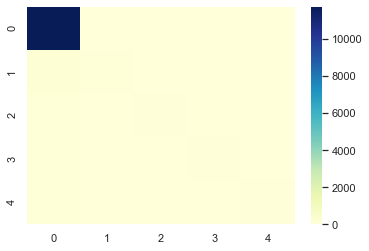

In [50]:
f = sns.heatmap(cm, cmap="YlGnBu")

In [97]:
predictions_rf.dtypes

[('machineID', 'string'),
 ('dt_truncated', 'timestamp'),
 ('label', 'double'),
 ('features', 'vector'),
 ('indexedLabel', 'double'),
 ('indexedFeatures', 'vector'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double')]

In [98]:
predictions_rf.show()

+---------+-------------------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|machineID|       dt_truncated|label|            features|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|
+---------+-------------------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|       60|2016-01-01 12:00:00|  0.0|[172.083928289341...|         0.0|[172.083928289341...|[81.8770230052474...|[0.81877023005247...|       0.0|
|       60|2016-01-01 00:00:00|  0.0|[168.173348120365...|         0.0|[168.173348120365...|[81.7363543709698...|[0.81736354370969...|       0.0|
|       60|2015-12-31 12:00:00|  0.0|[163.401030380918...|         0.0|[163.401030380918...|[81.7644393510118...|[0.81764439351011...|       0.0|
|       60|2015-12-31 00:00:00|  0.0|[166.997919179742...|         0.0|[166.997919179742...|[81.8770230052474...|[0.81877023

Area under ROC = 0.916055
Area under PR = 0.331882

Accuracy = 0.950422
Weighted Precision = 0.947038
Weighted Recall = 0.950422
F1 = 0.940725


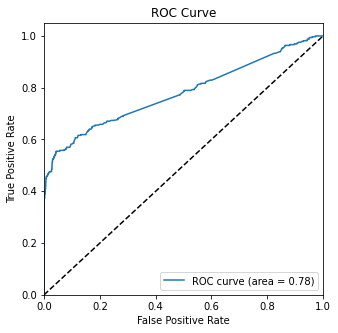

In [99]:
predictionAndLabels = predictions_rf.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('indexedLabel','probability').toPandas()
labels = predictions_rf_pddf["indexedLabel"]
prob = []
for dv in predictions_rf_pddf["probability"]:
    prob.append(dv.values[1])
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [100]:
# Use sklearn
rf_result = predictions_rf.select('indexedLabel', 'prediction').toPandas()

rf_label = rf_result['indexedLabel'].tolist()
rf_prediction = rf_result['prediction'].tolist()

precision, recall, fscore, support = score(rf_label, rf_prediction)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9533516  0.80503145 0.86538462 0.90361446 0.94      ]
recall: [0.99604377 0.3902439  0.40723982 0.35377358 0.28143713]
fscore: [0.9742302  0.52566735 0.55384615 0.50847458 0.43317972]
support: [11880   328   221   212   167]


In [101]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", 
                            featureSubsetStrategy="auto", impurity="gini", seed=123)

# Chain indexers and forest in a Pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf])


## Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxBins, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 7]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

## Define cross-validation
crossval = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="weightedPrecision"),
                          numFolds=3)

## Train model using CV
cvModel = crossval.fit(training)

In [102]:
datestamp = str(datetime.datetime.now());
rf_fileName = "CV_RandomForestClassificationModel";
rfDirfilename = '../models/' + rf_fileName;
cvModel.bestModel.save(rfDirfilename)

In [103]:
## Predict and evaluate
predictions = cvModel.transform(testing)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
r2 = evaluator.evaluate(predictions)
print("weightedPrecision on test data = %g" % r2)

weightedPrecision on test data = 0.948869


In [104]:
# Make predictions.
predictions_rf = cvModel.bestModel.transform(testing)
predictions_rf.groupby('indexedLabel', 'prediction').count().show()

+------------+----------+-----+
|indexedLabel|prediction|count|
+------------+----------+-----+
|         2.0|       0.0|  130|
|         1.0|       1.0|  128|
|         4.0|       2.0|    1|
|         0.0|       1.0|   22|
|         0.0|       4.0|    7|
|         1.0|       0.0|  200|
|         2.0|       2.0|   90|
|         2.0|       3.0|    1|
|         4.0|       4.0|   60|
|         0.0|       0.0|11841|
|         4.0|       3.0|    2|
|         0.0|       2.0|    4|
|         4.0|       0.0|   97|
|         3.0|       3.0|   73|
|         0.0|       3.0|    6|
|         3.0|       0.0|  139|
|         4.0|       1.0|    7|
+------------+----------+-----+



In [46]:
print("Best MaxDepth: ",cvModel.bestModel.stages[-1]._java_obj.getMaxDepth())
print("Best MaxBins: ",cvModel.bestModel.stages[-1]._java_obj.getMaxBins())
print("Best NumTrees: ",cvModel.bestModel.stages[-1]._java_obj.getNumTrees())
print("Best MinInstancesPerNode: ",cvModel.bestModel.stages[-1]._java_obj.getMinInstancesPerNode())


Best MaxDepth:  7
Best MaxBins:  20
Best NumTrees:  100
Best MinInstancesPerNode:  1


Area under ROC = 0.928533
Area under PR = 0.377725

Accuracy = 0.951905
Weighted Precision = 0.948869
Weighted Recall = 0.951905
F1 = 0.942692


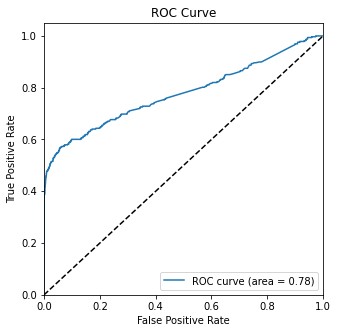

In [105]:
predictionAndLabels = predictions_rf.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions_rf, {evaluator.metricName: "f1"}))

# PLOT ROC curve after converting predictions to a Pandas dataframe
%matplotlib inline
predictions_rf_pddf = predictions_rf.select('indexedLabel','probability').toPandas()
labels = predictions_rf_pddf["indexedLabel"]
prob = []
for dv in predictions_rf_pddf["probability"]:
    prob.append(dv.values[1])
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [28]:
# loaded_model = PipelineModel.load("../models/CV_RandomForestClassificationModel/")

In [39]:
## Predict and evaluate
# predictions = model_rf.transform(testing)
# evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
# r2 = evaluator.evaluate(predictions)
# print("weightedPrecision on test data = %g" % r2)

Let's have a look at the most important discriminating features to the Random Forest.

In [40]:
def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

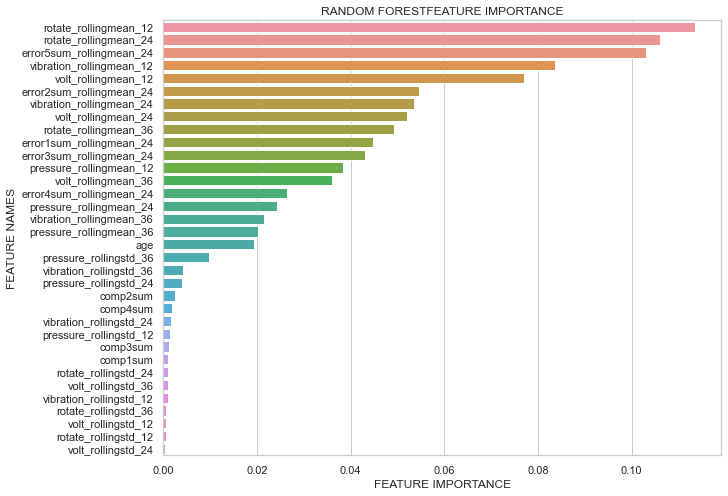

In [38]:
plot_feature_importance(model_rf.stages[-1].featureImportances, input_features,'RANDOM FOREST')

Surprisingly, the age is less important that we thought. Top 3 features were: 

- rotate_rollingmean_12, 
- rotate_rollingmean_23 and 
- error5sum_rollingmean_24.